In [129]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [130]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [ ]:
train = pd.read_csv(r"train.csv")
X = train.drop(columns="SalePrice")
y = train["SalePrice"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)

In [133]:
X_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
433    434          60       RL        100.0    10839   Pave   NaN      IR1   
593    594         120       RM          NaN     4435   Pave   NaN      Reg   
1122  1123          20       RL          NaN     8926   Pave   NaN      IR1   
175    176          20       RL         84.0    12615   Pave   NaN      Reg   
292    293          50       RL         60.0    11409   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
433          Lvl    AllPub  ...           0        0    NaN    NaN   
593          Lvl    AllPub  ...           0        0    NaN    NaN   
1122         Lvl    AllPub  ...         160        0    NaN  MnPrv   
175          Lvl    AllPub  ...           0        0    NaN  MnPrv   
292          Lvl    AllPub  ...         160        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
433          NaN       0      7    2008        WD         Normal  
593          NaN       0      5    2009        WD         Normal  
1122         NaN       0     10    2009       COD        Abnorml  
175          NaN       0      6    2007        WD         Normal  
292          NaN       0      1    2009        WD         Normal  

[5 rows x 80 columns]

In [135]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 433 to 931
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    961 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          75 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallCond 

## Quais os objetivos dessa Análise? 
1. Identificar quais as variáveis que melhor explicam a variação do preço das casas
2. Criar um modelo de regressão que prevê o valor das casas
3. Criar um modelo que identifica se uma casa é uma anomalia com base no restante dos dados (Ad-malicioso, por exemplo)
4. Identificar casas com valores abaixo do valor do mercado

Quais variáveis explicam melhor a variação do preço das casas? 

In [136]:
# Mapping utilizado com base em reposta de IA para tornar os nomes mais descritivos:
value_mapping = {
    # Road and Alley Surfaces
    "Grvl": "Gravel",
    "Pave": "Paved",
    "NA": "No Access",  # Used for alleys and basements
    # Lot Shape
    "Reg": "Regular",
    "IR1": "Slightly Irregular",
    "IR2": "Moderately Irregular",
    "IR3": "Irregular",
    # Land Contour
    "Lvl": "Near Flat/Level",
    "Bnk": "Banked",
    "HLS": "Hillside",
    "Low": "Depression",
    # Utilities
    "AllPub": "All Public Utilities",
    "NoSewr": "No Sewer (Septic Tank)",
    "NoSeWa": "No Sewer or Water",
    "ELO": "Electricity Only",
    # Lot Config
    "Inside": "Inside Lot",
    "Corner": "Corner Lot",
    "CulDSac": "Cul-de-sac",
    "FR2": "Frontage on 2 Sides",
    "FR3": "Frontage on 3 Sides",
    # Land Slope
    "Gtl": "Gentle Slope",
    "Mod": "Moderate Slope",
    "Sev": "Severe Slope",
    # Condition (Condition1 & Condition2)
    "Artery": "Adjacent to Arterial Street",
    "Feedr": "Adjacent to Feeder Street",
    "Norm": "Normal",
    "RRNn": "Near N-S Railroad",
    "RRAn": "Adjacent to N-S Railroad",
    "RRNe": "Near E-W Railroad",
    "RRAe": "Adjacent to E-W Railroad",
    "PosN": "Near Positive Off-site Feature",
    "PosA": "Adjacent to Positive Off-site Feature",
    # Building Type
    "1Fam": "Single-family Detached",
    "2FmCon": "Two-family Conversion",
    "Duplx": "Duplex",
    "TwnhsE": "Townhouse End Unit",
    "TwnhsI": "Townhouse Inside Unit",
    # House Style
    "1Story": "One Story",
    "1.5Fin": "One and Half Story Finished",
    "1.5Unf": "One and Half Story Unfinished",
    "2Story": "Two Story",
    "2.5Fin": "Two and Half Story Finished",
    "2.5Unf": "Two and Half Story Unfinished",
    "SFoyer": "Split Foyer",
    "SLvl": "Split Level",
    # Quality and Condition Ratings
    "Ex": "Excellent",
    "Gd": "Good",
    "TA": "Typical/Average",
    "Fa": "Fair",
    "Po": "Poor",
    # Basement Specific
    "Av": "Average Exposure",
    "Mn": "Minimum Exposure",
    "No": "No Exposure",
    "GLQ": "Good Living Quarters",
    "ALQ": "Average Living Quarters",
    "BLQ": "Below Average Living Quarters",
    "Rec": "Recreation Room",
    "LwQ": "Low Quality",
    "Unf": "Unfinished",
    # Heating
    "Floor": "Floor Furnace",
    "GasA": "Gas Forced Warm Air",
    "GasW": "Gas Hot Water or Steam",
    "Grav": "Gravity Furnace",
    "OthW": "Other Water Heater",
    "Wall": "Wall Furnace",
    # Central Air
    "Y": "Yes",
    "N": "No",
    # Electrical
    "SBrkr": "Standard Circuit Breakers",
    "FuseA": "Fuse Box >60AMP + Romex",
    "FuseF": "60AMP Fuse Box + Mostly Romex",
    "FuseP": "60AMP + Mostly Knob & Tube",
    "Mix": "Mixed Wiring",
    # Kitchen Quality
    # Already mapped above: Ex, Gd, TA, Fa, Po
    # Functional
    "Typ": "Typical Functionality",
    "Min1": "Minor Deductions 1",
    "Min2": "Minor Deductions 2",
    "Mod": "Moderate Deductions",
    "Maj1": "Major Deductions 1",
    "Maj2": "Major Deductions 2",
    "Sev": "Severely Damaged",
    "Sal": "Salvage Only",
    # Fireplace Quality
    # Already mapped above: Ex, Gd, TA, Fa, Po, NA
    # Garage Type
    "2Types": "More than One Type",
    "Attchd": "Attached",
    "Basment": "Basement",
    "BuiltIn": "Built-In",
}

map_zoneamento = {
    "A": "Agriculture",
    "C": "Commercial",
    "FV": "Floating Village Residential",
    "I": "Industrial",
    "RH": "Residential High Density",
    "RL": "Residential Low Density",
    "RP": "Residential Low Density Park ",
    "RM": "Residential Medium Density",
}

In [157]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Optional

class MappingValues(BaseEstimator, TransformerMixin):
    def __init__(self, dicionario, col: Optional[str] = None):
        self.dicionario = dicionario
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if self.col is not None:
            X_transformed[self.col] = X_transformed[self.col].replace(self.dicionario)
        else:
            X_transformed = X_transformed.replace(self.dicionario)
        return X_transformed

In [158]:
mapper = MappingValues(map_zoneamento,"MSZoning")
X_train = mapper.transform(X_train)

In [159]:
new_mapper = MappingValues(value_mapping)
X_train = new_mapper.transform(X_train)

## Verificação de qualidade de dados

In [160]:
n = len(X_train.count())
nulos = X_train.isnull().sum().reset_index()
nulos["relativa"] = round(nulos[0]/n,0)
nulos.sort_values(by="relativa",ascending=False)

index    0  relativa
3     LotFrontage  207       3.0
0              Id    0       0.0
1      MSSubClass    0       0.0
2        MSZoning    0       0.0
4         LotArea    0       0.0
..            ...  ...       ...
75        MiscVal    0       0.0
76         MoSold    0       0.0
77         YrSold    0       0.0
78       SaleType    0       0.0
79  SaleCondition    0       0.0

[80 rows x 3 columns]

In [162]:
from sklearn.base import BaseEstimator, TransformerMixin    

class NullReplacer(BaseEstimator,TransformerMixin):
    
    def __init__(self,columns):
        if isinstance(columns,str):
            self.columns = [columns]
        else:
            self.columns = columns
            
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].fillna("None")
                
        return X_transformed

In [163]:
X_train.isnull().sum().sort_values(ascending=False)

LotFrontage      207
MasVnrArea         3
Electrical         1
Id                 0
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

In [164]:
lista = [
    "MiscFeature","Alley","Fence","MasVnrType","FireplaceQu","GarageCond","GarageQual",
    "GarageFinish","GarageCond", "GarageQual", "GarageFinish","GarageType","GarageYrBlt", 
    "BsmtExposure", "BsmtFinType2", "BsmtCond","BsmtFinType1", "BsmtQual","PoolQC"
]

null_replacer = NullReplacer(lista)
for col in lista:
    X_train = null_replacer.transform(X_train)

X_train.isnull().sum().sort_values(ascending=False)

LotFrontage      207
MasVnrArea         3
Electrical         1
Id                 0
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64

In [167]:
knn = KNNImputer()
X_train["LotFrontage"] = knn.fit_transform(X_train[["LotFrontage"]])

In [168]:
X_train.isnull().sum().sort_values(ascending=False)

MasVnrArea       3
Electrical       1
Id               0
MSSubClass       0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 80, dtype: int64

In [169]:
X_train = X_train.dropna()

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

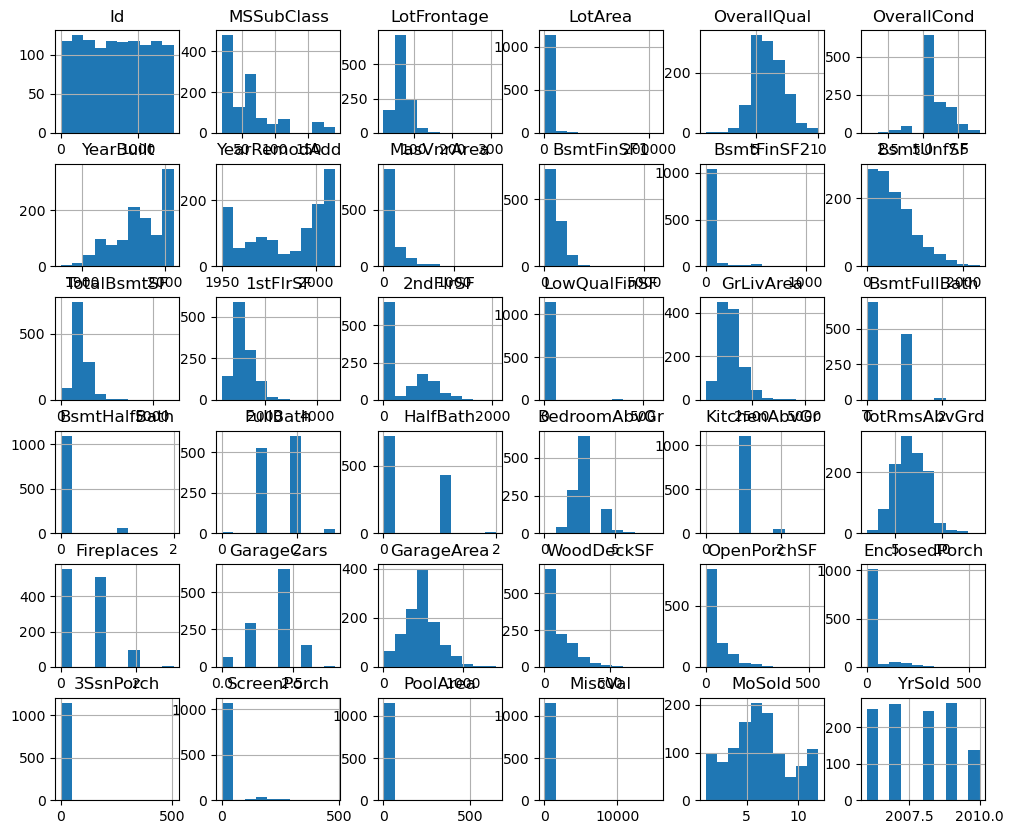

In [171]:
X_train.hist(figsize=(12,10))

In [185]:
y_train.shape
X_train.shape

(1164, 80)

In [186]:
y_train = y_train.loc[X_train.index]


def show_plot():   
    n_cols = 6
    n_rows = int(np.ceil(len(X_train.select_dtypes(include="number")) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(X_train.select_dtypes(include="number")):
        ax = axes[i]
        try:
            modelo = LinearRegression()
            X_train_value = X_train[[col]]
            modelo.fit(X_train_value, y_train)
            previsao = modelo.predict(X_train_value)

            r2 = round(r2_score(y_train, previsao), 2)
            mse = round(mean_squared_error(y_train, previsao), 0)

            sns.scatterplot(data=X_train_value, x=col, y=y_train, ax=ax, label=f"r2: {r2}\nmse: {mse}")
            sns.lineplot(x=X_train[col], y=previsao, color='red', ax=ax)

            ax.set_title(col)
            ax.legend()
        except Exception as e:
            ax.set_visible(False)
            print(f"Skipped {col} due to error: {e}")

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


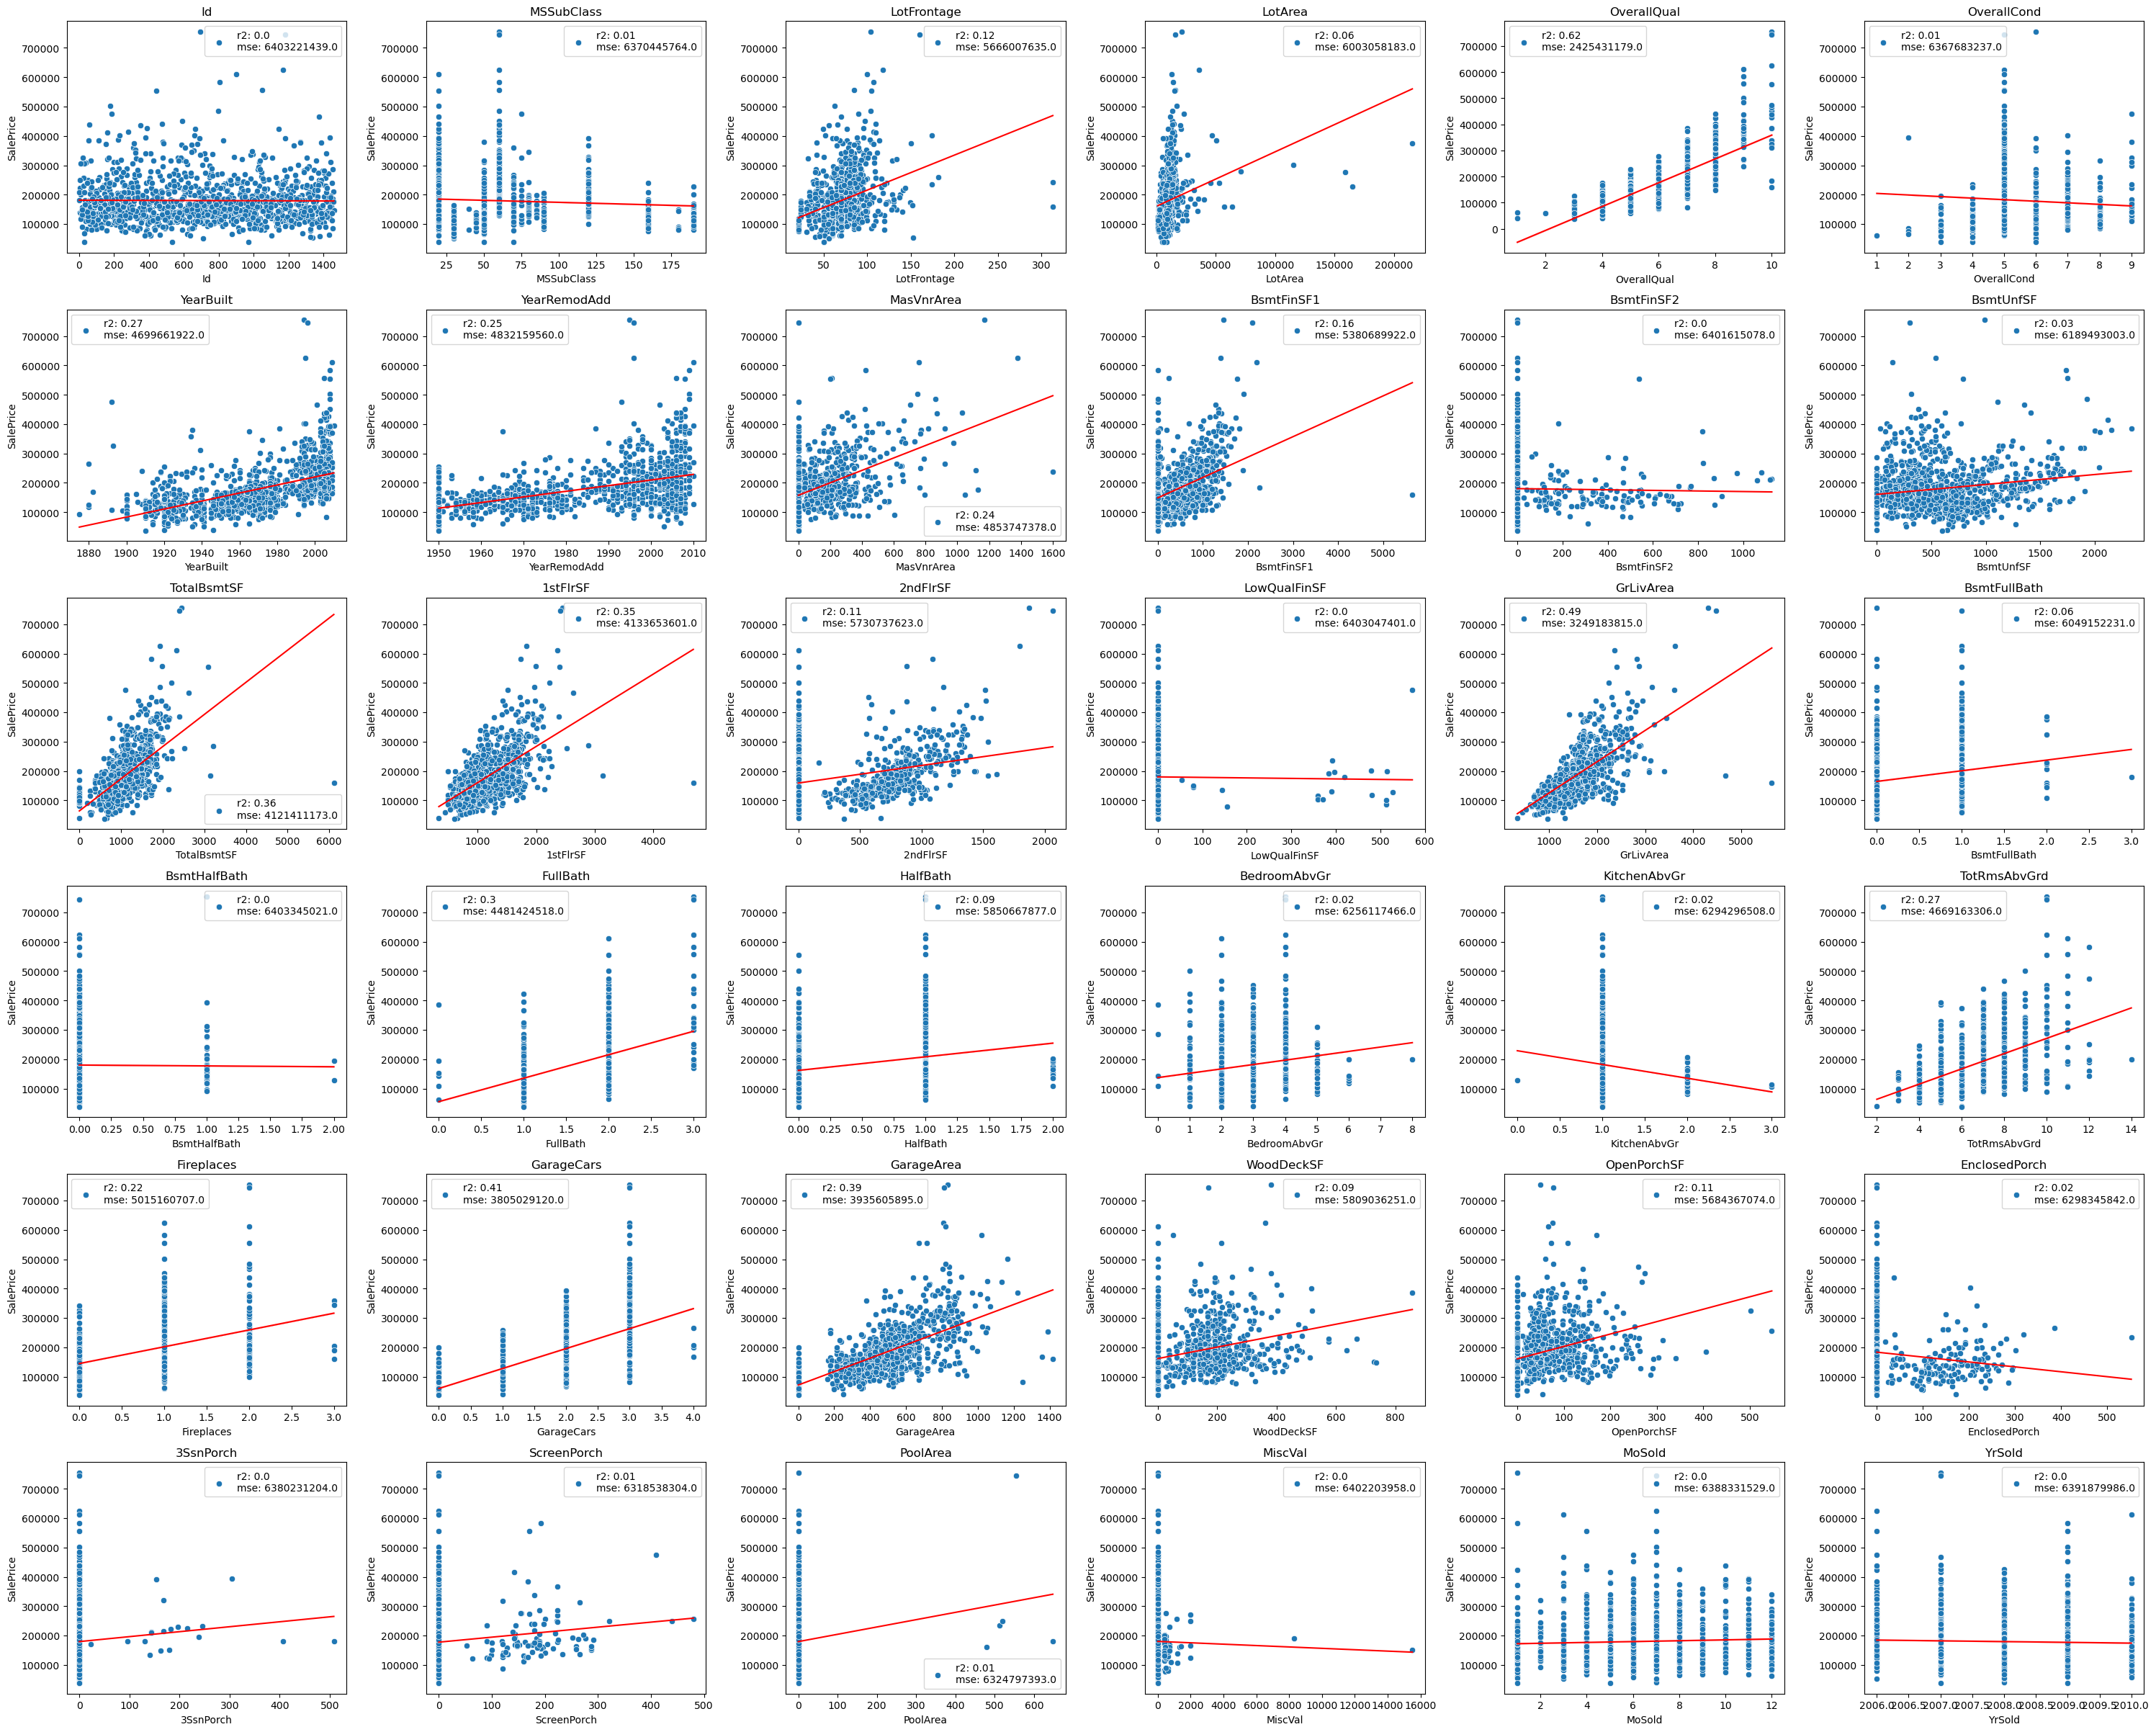

In [187]:
show_plot()

## CONSERTAR RESTANTE DO CODIGO

Realizando a remoção de alguns outliers:

In [113]:
train = train[train["SalePrice"] <= 500000]
train = train[train["GrLivArea"] <= 4000]
train = train[train["TotalBsmtSF"] <= 3000]

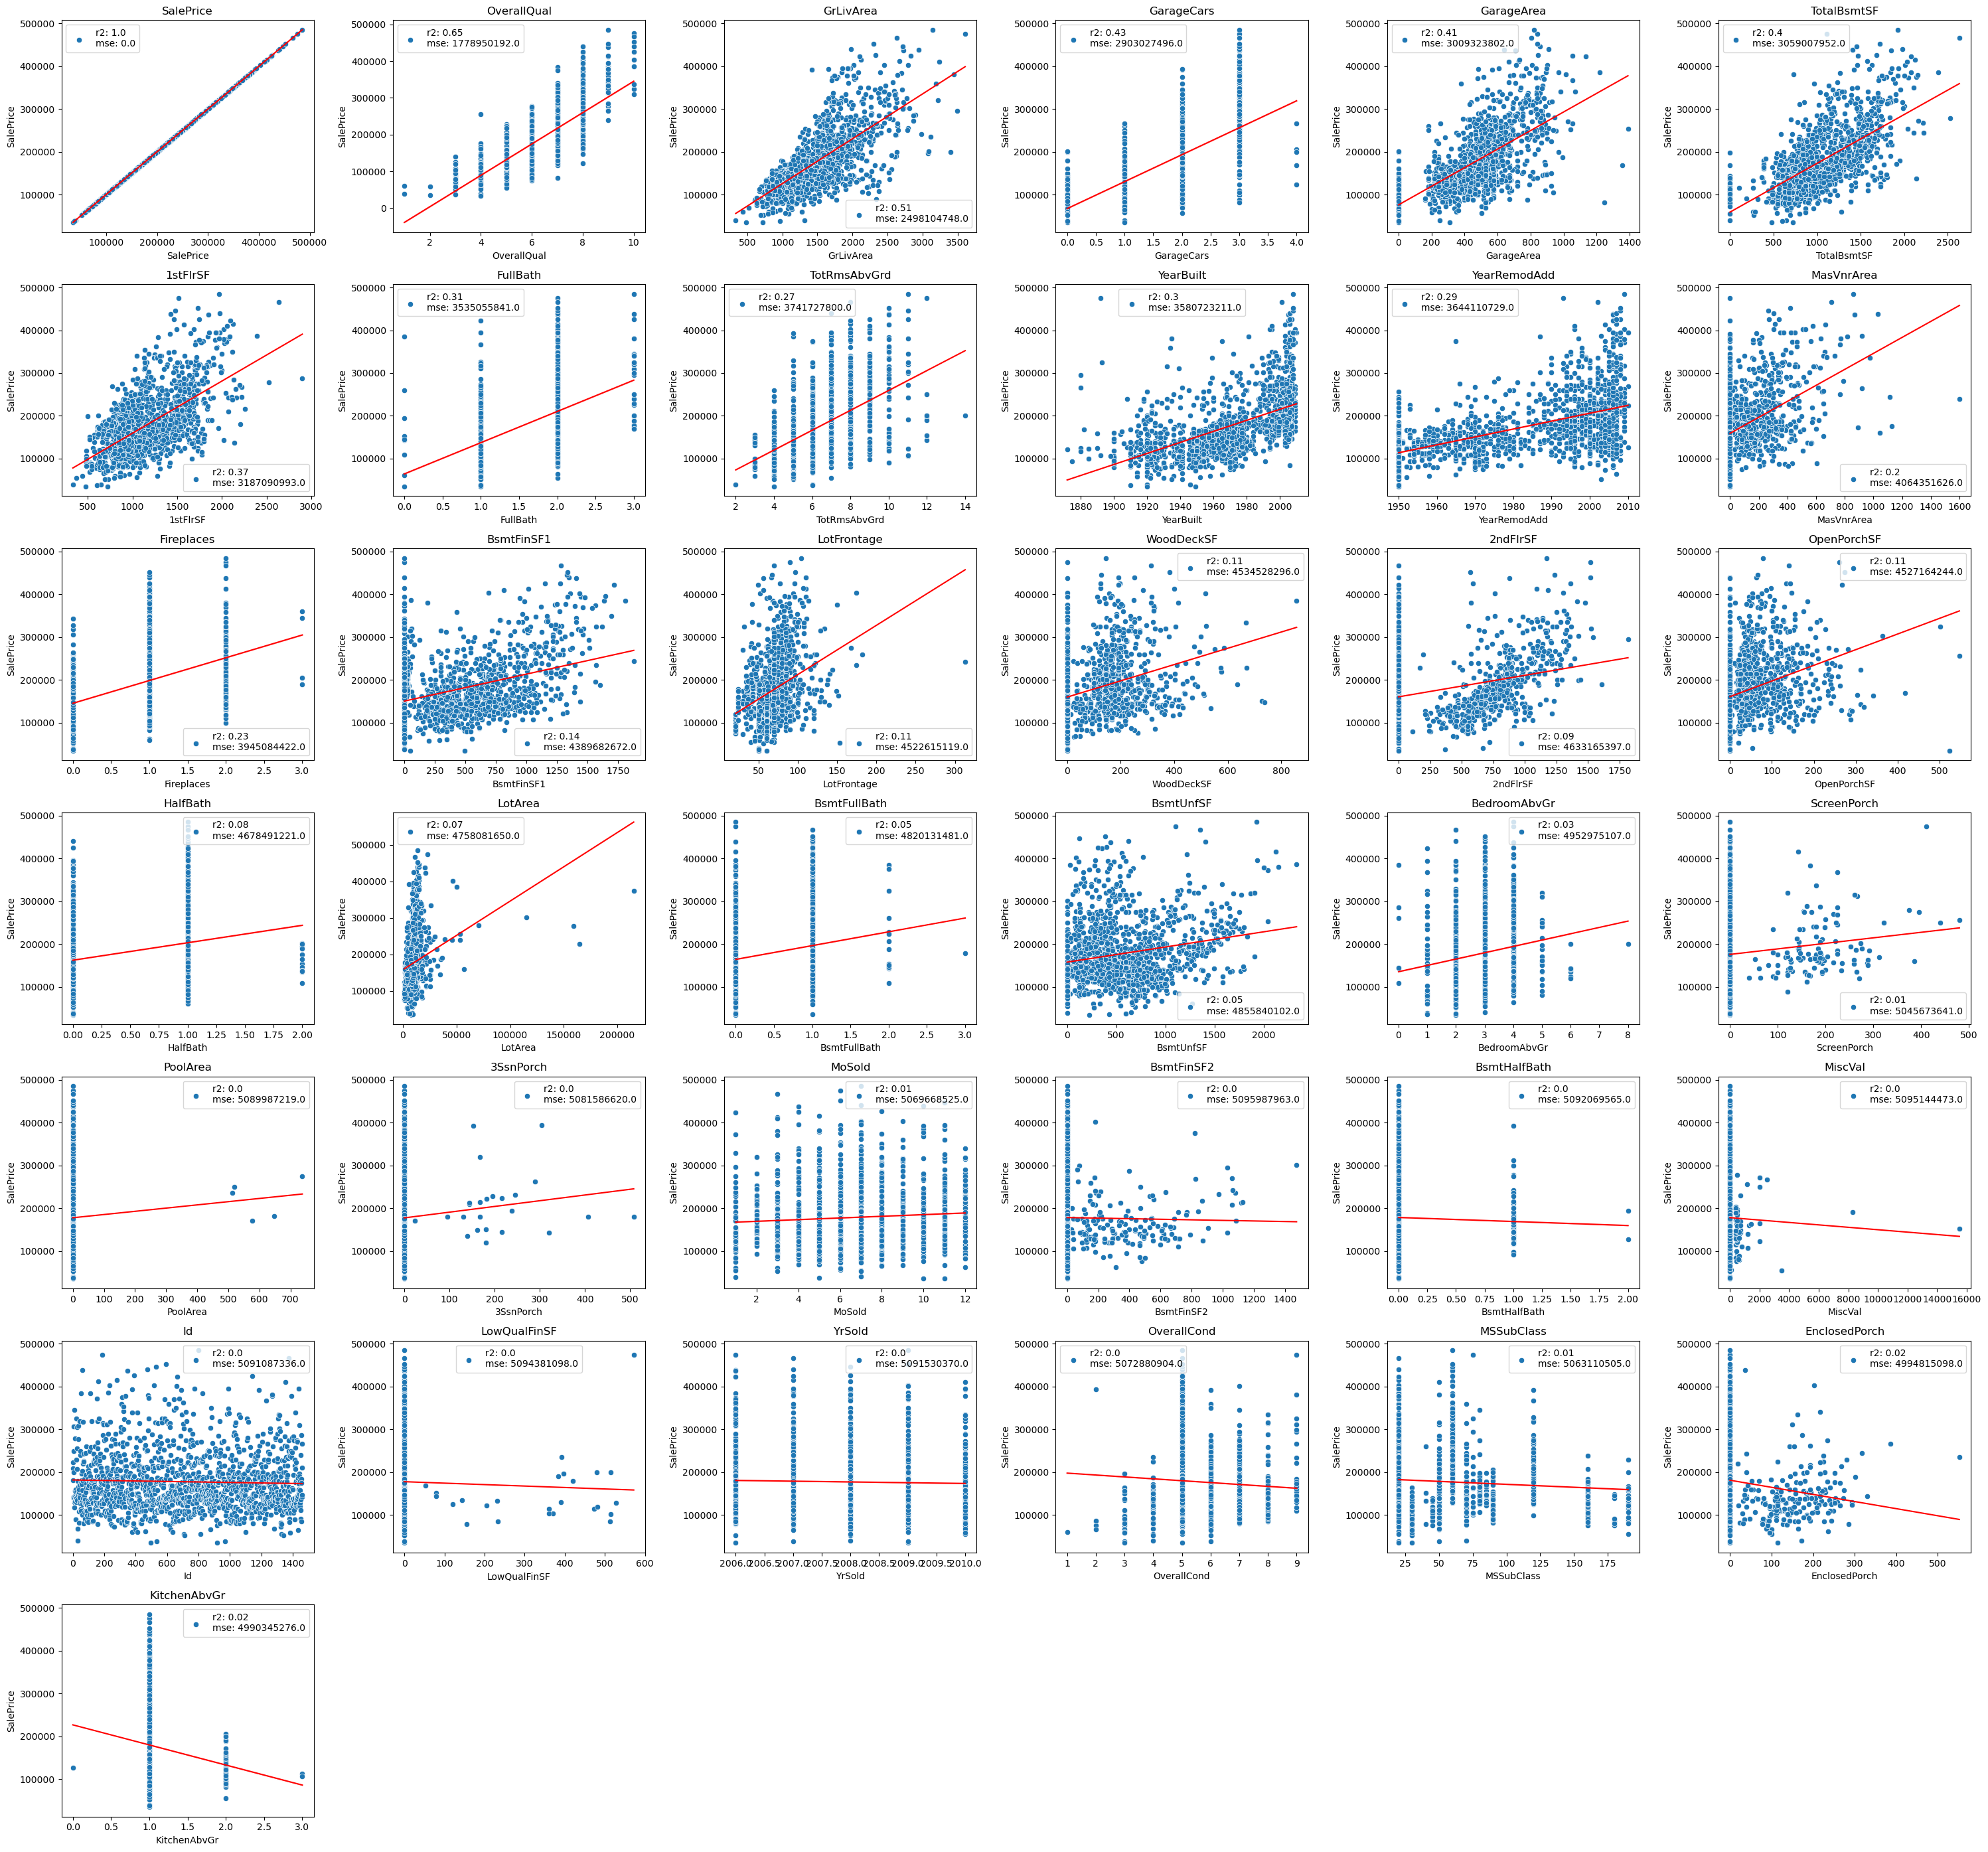

In [114]:
show_plot()

### Verificando Distribuição de preço de acordo com boxplots. Criando uma função que permita visualizar os dados de acordo com os valores únicos.

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns


def tabela_de_frequencia(df, col, col_target):
    """
    Gera um DataFrame com:
    - Frequência absoluta
    - Frequência relativa (%)
    - Estatísticas de col_target (média, mediana, std, min, max, Q1, Q3)

    Args:
        df (pd.DataFrame): DataFrame de entrada
        col (str): Nome da coluna categórica a ser analisada

    Returns:
        pd.DataFrame: Tabela resumo com frequências e estatísticas de posição e dispersão
    """

    frequencias = df[col].value_counts(dropna=False)
    frequencias_rel = df[col].value_counts(normalize=True, dropna=False) * 100

    # Estatísticas de SalePrice por categoria
    estatisticas = df.groupby(col)[col_target].agg(
        q25=lambda x: x.quantile(0.25),
        media="mean",
        mediana="median",
        desvio_padrao="std",
        q75=lambda x: x.quantile(0.75),
        maximo="max"
    )

    tabela = pd.DataFrame(
        {
            col: frequencias.index,
            "Frequência Absoluta": frequencias.values,
            "Frequência Relativa (%)": frequencias_rel.values,
        }
    ).set_index(col)

    tabela = tabela.join(estatisticas)
    tabela = tabela.round(2)

    return tabela.reset_index()


def visualizacao_box_plot(df, col, col_target):
    """
    Gera um boxplot para a coluna col comparando com SalePrice.

    Parâmetros:
    - df: DataFrame pandas contendo os dados
    - col: string, nome da coluna categórica a ser usada no eixo X
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=col, y=col_target, hue=col, legend=False)
    plt.title(f"Boxplot de SalePrice por {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### A classifação da área Impacta no preço do empreendimento?

C:\Users\LuizGuilhermedaSilva\AppData\Local\Temp\ipykernel_31204\3945093240.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LuizGuilhermedaSilva\AppData\Local\Temp\ipykernel_31204\3945093240.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LuizGuilhermedaSilva\AppData\Local\Temp\ipykernel_31204\3945093240.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\LuizGuilhermedaSilva\AppData\Local\Temp\ipykernel_31204\3945093240.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

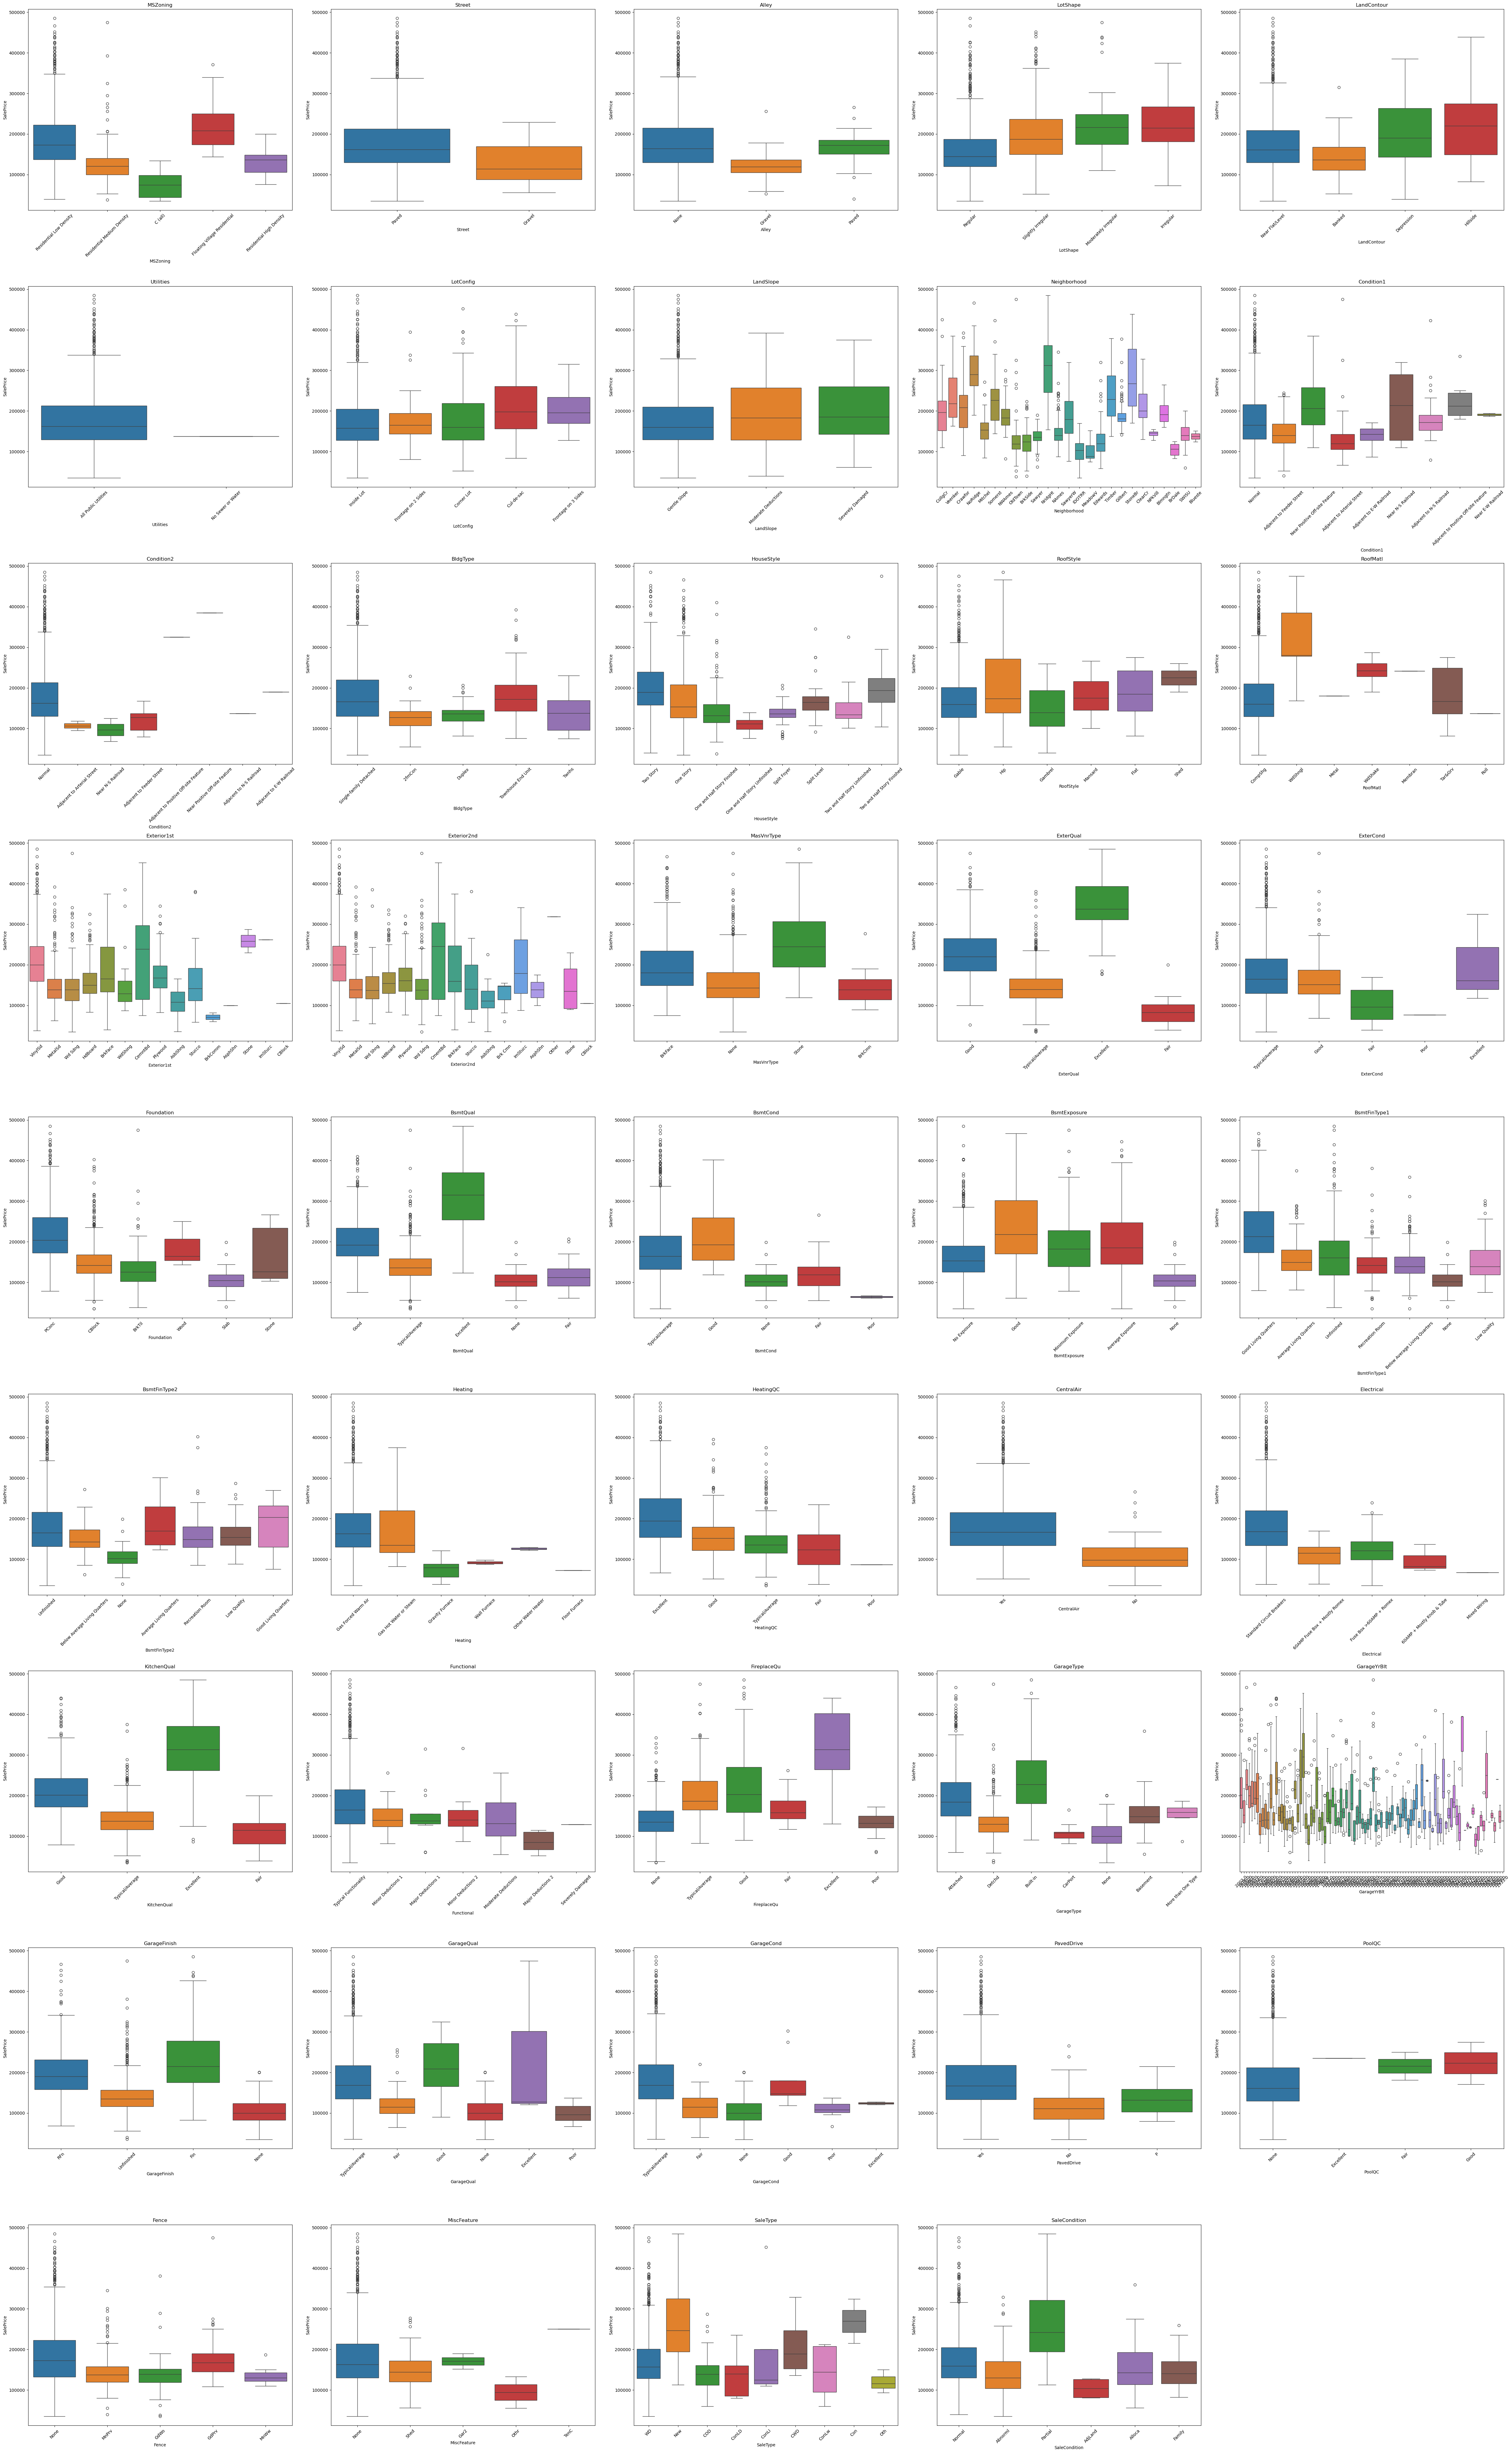

In [128]:
colunas = train.select_dtypes(include="object").columns
n_cols = 5 
n_rows = int(np.ceil(len(colunas) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*10, n_rows*9))
axes = axes.flatten()

for i, col in enumerate(colunas):
    ax = axes[i]
    try:
        sns.boxplot(data=train, x=col, y="SalePrice", hue=col, ax=ax, legend=False)
        ax.set_title(col)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    except Exception as e:
        ax.set_visible(False)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [117]:
tabela_de_frequencia(train, "MSZoning", "SalePrice")

MSZoning  Frequência Absoluta  Frequência Relativa (%)  \
0       Residential Low Density                 1132                    78.72   
1    Residential Medium Density                  218                    15.16   
2  Floating Village Residential                   62                     4.31   
3      Residential High Density                   16                     1.11   
4                       C (all)                   10                     0.70   

         q25      media   mediana  desvio_padrao       q75  maximo  
0  137337.50  187142.64  173000.0       71068.88  222125.0  485000  
1  100000.00  126316.83  120500.0       48521.69  140000.0  475000  
2  173799.75  214888.13  207900.0       53437.37  250000.0  370878  
3  106150.00  131558.38  136500.0       35714.12  148608.5  200000  
4   43998.25   74528.00   74700.0       33791.09   98332.0  133900

#### Principais pontos da Zona:
1. O dataset é composto majoritariamente por partes residenciais de baixa densidade.
2. O Conjunto de baixa densidade possui um número alto de dispersão, com o maior desvio padrão entre as séries, isso provavelmente se deve ao fato que tanto residências em locais de pouca habitação como regiões mais rurais e regiões mais ricas onde o número de casas é menor devido a extensão das casas pode explicar esse fato.
3. Podemos fazer uma verificação do tamanho das casas em cada MSZoning para verificar se existe essa relação, dado que casas mais caras podem ser casas maiores, o que causaria o aumento do preço.

Para verificar isso, podemos identificar a distribuição de tamanho de casas para casa tipo de zona

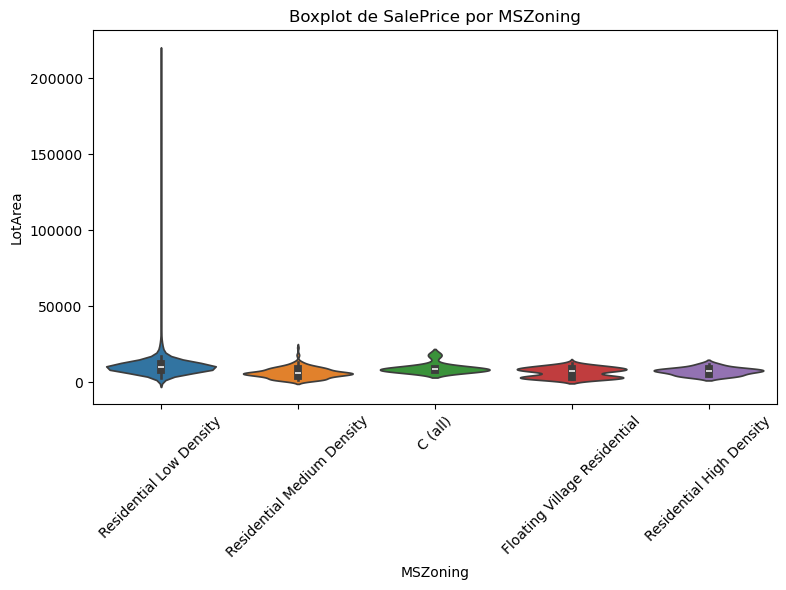

In [118]:
visualizacao_box_plot(train, "MSZoning", "LotArea")

Como esperado, as residências em regiões de baixa densidade também contém os outliers em relação com tamanho residencial. Com relação a distribuição de residências com baixa residência, é estimado que 45% da área de Ames é relacionada com residências de unifamiliares, que geralmente são classificadas como baixa densidade residencial.
[Referência: Zoneamento de Ames, Iowa](https://www.zoneomics.com/zoning-maps/iowa/ames?utm_source=chatgpt.com)

Entretanto, considerando o exposto, podemos tentar entender o preço da residência de acordo com o tamanho de sua extensão, vamos verificar isso com um gráfico de correlação entre preço e tamanho da área e verificar como se distribuem de acordo com o Zoneamento